# Binance

- Créér un clé API : https://www.binance.com/en/support/faq/360002502072
- **Quand elle est créée garder en mémoire l'api key et la secret KEY**

- créer un fichier config.cfg dans le même répertoire que le notebook et remplacer les valeurs par celles de l'API créée

```cfg
[BINANCE]
API_KEY = YOUR KEY                  # A MODIFIER
SECRET_KEY = YOUR SECRET KEY        # A MODIFIER
```

- installer le package python-binance 

```shell
pip install python-binance
ou
py -m pip install python-binance
ou autre
```
- Editer la list my_coins avec vos crypto

```python
#exemple
my_coins = ['BTC','USDT', 'ETH']     # A ADAPTER
```

- Editer le dict stack car l'API ne sait pas encore récupérer les crypto stackées 

```python
#exemple
stack = {'DOT':3, 'ADA':6.1938, 'CAKE':3.125, 'TRX': 67}      # A ADAPTER
```

- et lancer tout les cellules
! Tout est en dollars


In [1]:
import requests, json, time, hashlib,hmac, configparser
from binance import Client
# A ADAPTER
my_coins = ['BTC', 'ETH', 'ADA', 'DOT', 'MATIC', 'KSM', 'CAKE', 'VET', 'SOL', 'BNB', 'LTC', 'THETA', 'AVAX', 'DENT', 'EGLD', 'HOT', 'TRX', 'ONE', 'BAND', 'SXP', 'LINK', 'UTK', 'USDT', 'BUSD']  
my_symbols = [coin + 'USDT' for coin in my_coins]

config = configparser.ConfigParser()
config.read_file(open('config.cfg'))

KEY = config.get('BINANCE', 'API_KEY')
SECRET_KEY = config.get('BINANCE', 'SECRET_KEY')
BASE_URL = 'https://api.binance.com/'

client = Client(KEY, SECRET_KEY)


In [2]:
from urllib.parse import urlencode

# fonctions utilitaires

def get_timestamp():
    return int(time.time() * 1000)

def hashing(query_string):
    return hmac.new(SECRET_KEY.encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256).hexdigest()

def dispatch_request(http_method):
    session = requests.Session()
    session.headers.update({
        'Content-Type': 'application/json;charset=utf-8',
        'X-MBX-APIKEY': KEY
    })
    return {
        'GET': session.get,
        'DELETE': session.delete,
        'PUT': session.put,
        'POST': session.post,
    }.get(http_method, 'GET')

def send_signed_request(http_method, url_path, payload={}):
    query_string = urlencode(payload, True)
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, get_timestamp())
    else:
        query_string = 'timestamp={}'.format(get_timestamp())

    url = BASE_URL + url_path + '?' + query_string + '&signature=' + hashing(query_string)
    print("{} {}".format(http_method, url))
    params = {'url': url, 'params': {}}
    response = dispatch_request(http_method)(**params)
    return response.json()


In [3]:
# Create wallet
def create_wallet():
    wallet = {}
    for asset in my_coins:
        wallet[asset] = {'Price':0, 'Current_market_price':0, 'Buy_price': 0, 'Qty':0, 'Saving_value':0, 'Spot_value':0, 'Stack_value':0, 'Balance':0, 'ATH': 0, 'ATH_percent':0, 'Buy_price_percent':0, 'earn':0}
    return wallet

In [4]:
# Get order history
def update_order_history(wallet):
    for symbol in my_symbols:
        
        if symbol != 'USDTUSDT' and symbol != 'BUSDUSDT':
            orders_history = client.get_all_orders(symbol=symbol)
            sum_coin = 0.0
            sum_cost = 0.0
            sell_coin = 0.0
            sell_cost = 0.0
            for order in orders_history:
                if order['side'] == 'BUY':
                    sum_cost += float(order['executedQty']) * float(order['price'])
                    sum_coin += float(order['executedQty']) 
                elif order['side'] == 'SELL':
                    # sum_cost -= float(order['executedQty']) * float(order['price'])
                    # sum_coin -= float(order['executedQty']) 
                    sell_cost +=  float(order['executedQty']) * float(order['price'])
                    sell_coin += float(order['executedQty'])
            print(symbol, sum_coin, sum_cost)
            wallet[symbol.replace('USDT', '')]['Qty'] = sum_coin - sell_coin
            wallet[symbol.replace('USDT', '')]['Price'] =sum_cost
            wallet[symbol.replace('USDT', '')]['Buy_price'] = sum_cost / sum_coin
            wallet[symbol.replace('USDT', '')]['earn'] = sell_cost

In [5]:
def update_market_price(wallet):
    all_coins = client.get_all_tickers()
    for asset in my_coins:
        if asset != 'USDT':
            for symbol in all_coins:
                if symbol['symbol'] == asset+'USDT':
                    wallet[asset]['Current_market_price'] = float(symbol['price'])

In [6]:
# Get current Savings
def update_saving(wallet):
    saving = send_signed_request('GET', 'sapi/v1/lending/union/account')
    savings = saving['positionAmountVos']
    for asset in savings:
        wallet[asset['asset']]["Saving_value"] = float(asset['amountInUSDT'])

In [7]:
# stop value
def update_spot(wallet):
    spot = send_signed_request('GET', 'api/v3/account')

    for asset in my_coins:
        for asset_spot in spot["balances"]:
            if asset_spot['asset'] == asset:
                if asset != "USDT":
                    wallet[asset]['Spot_value'] = wallet[asset]['Current_market_price'] * float(asset_spot['free'])
                else:
                    wallet[asset]['Spot_value'] = float(asset_spot['free'])

In [8]:
# get stacking value
def update_stacking(wallet):    
    # A ADAPTER
    stack = {'ADA':17+6.247+18.94+7.992+14.5+8.02,  'KSM':0.14+0.1599, 'MATIC':65+97.1, 'VET':387 , 'CAKE':1.785, 'SOL':0.56 }
    for asset in my_coins:
        try:
            coin = stack[asset]
            wallet[asset]['Stack_value'] = wallet[asset]['Current_market_price'] * coin
        except:
            pass

In [9]:
# balance calcul
def update_balance(wallet):
    for asset in my_coins:
        wallet[asset]["Balance"] =  wallet[asset]["Stack_value"] + wallet[asset]["Saving_value"] + wallet[asset]["Spot_value"] -  wallet[asset]["Price"] + wallet[asset]["earn"]

In [10]:
# Get ATH
def update_ath(wallet):
    for asset in my_coins:
        if asset != 'USDT':
            earliest_timestamp = client._get_earliest_valid_timestamp(asset + 'USDT', '1d')  # Here "ETHUSDT" is a trading pair and "1d" is time interval
            candle = client.get_historical_klines(asset + 'USDT', Client.KLINE_INTERVAL_1WEEK, "1 May, 2021")
            max_asset = 0
            for c in candle:
                if float(c[2]) > max_asset:
                    max_asset = float(c[2])
            wallet[asset]['ATH'] = max_asset
            wallet[asset]['ATH_percent'] = wallet[asset]['Current_market_price'] / wallet[asset]['ATH'] 

In [11]:
def update_buy_price_percent(wallet):
    for asset in my_coins:
        if wallet[asset]['Current_market_price'] != 0:
            wallet[asset]['Buy_price_percent'] = wallet[asset]['Buy_price']  / wallet[asset]['Current_market_price'] 

In [12]:
def main():
    wallet = create_wallet()
    update_market_price(wallet)
    update_order_history(wallet)
    update_ath(wallet)
    update_market_price(wallet)
    update_saving(wallet)
    update_spot(wallet)
    update_stacking(wallet)
    update_balance(wallet)
    update_buy_price_percent(wallet)
    with open("binance.json", "w") as outfile: 
        json.dump(wallet, outfile)
    return wallet

wallet = main()

BTCUSDT 0.004371 170.44899999999998
ETHUSDT 0.06186 149.85336999999998
ADAUSDT 72.32 102.76088000000001
DOTUSDT 9.499 206.40872
MATICUSDT 177.00000000000003 282.83872199999996
KSMUSDT 0.3408 102.922
CAKEUSDT 4.895 76.0046
VETUSDT 497.6 55.7578
SOLUSDT 0.564 19.946423999999997
BNBUSDT 0.016 10.15776
LTCUSDT 0.106 30.442
THETAUSDT 2.0 21.0
AVAXUSDT 0.265 10.0965
DENTUSDT 1050.0 10.185
EGLDUSDT 0.053 10.0859
HOTUSDT 660.0 10.131
TRXUSDT 67.0 10.116999999999999
ONEUSDT 79.0 10.1278
BANDUSDT 1.181 19.99433
SXPUSDT 7.385 31.395599999999995
LINKUSDT 0.215 10.019
UTKUSDT 19.0 10.260000000000002
GET https://api.binance.com/sapi/v1/lending/union/account?timestamp=1625666998990&signature=42e4a28b48219bd5393a3acf333d5021e6fc6d3d926e2498b5f4cddb822d783e
GET https://api.binance.com/api/v3/account?timestamp=1625666999329&signature=63bc21761834a6322eef2b9fa7ff5b6c468f4a6f799000c823b603cfc0dd1c89


In [13]:
import pandas as pd
pd.DataFrame.from_dict(wallet,  orient='index')

,Price,Current_market_price,Buy_price,Qty,Saving_value,Spot_value,Stack_value,Balance,ATH,ATH_percent,Buy_price_percent,earn
BTC,170.449000,34789.780000,38995.424388,0.004371,152.259746,0.000000,0.000000,-18.189254,59500.000000,0.584825,1.120887,0.0000
ETH,149.853370,2381.010000,2422.459909,0.061860,147.245405,0.000000,0.000000,-2.607965,4372.720000,0.544652,1.017409,0.0000
ADA,102.760880,1.432100,1.420919,72.320000,0.161245,0.000000,104.112238,1.512603,2.470000,0.579919,0.992193,0.0000
DOT,206.408720,17.162000,21.729521,9.499000,164.003851,0.000000,0.000000,-42.404869,49.780000,0.344757,1.266142,0.0000
MATIC,282.838722,1.152820,1.597959,177.000000,20.554508,0.000000,186.872122,-75.412092,2.700000,0.427193,1.386130,0.0000
KSM,102.922000,240.230000,302.001174,0.340800,0.000000,10.443146,72.044977,-20.433877,625.000000,0.384048,1.257133,0.0000
CAKE,76.004600,15.841000,15.526987,1.726000,0.451942,0.000000,28.276185,5.962727,42.980000,0.368567,0.980177,53.2392
VET,55.757800,0.085130,0.112053,497.600000,9.355687,0.000000,32.945310,-13.456803,0.250000,0.340760,1.316263,0.0000
SOL,19.946424,37.005000,35.366000,0.564000,0.000000,0.036786,20.722800,0.813162,58.380000,0.634395,0.955709,0.0000
BNB,10.157760,337.840000,634.860000,0.016000,4.738333,0.000000,0.000000,-5.419427,691.770000,0.488746,1.879174,0.0000


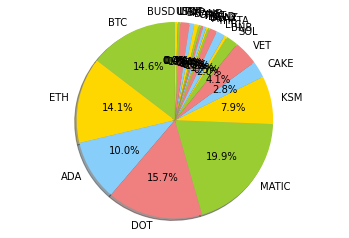

In [14]:
import matplotlib.pyplot as plt

labels = [asset for asset in my_coins]
sizes = [wallet[asset]['Spot_value'] + wallet[asset]['Saving_value'] + wallet[asset]['Stack_value'] for asset in  my_coins]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [15]:
## Bilan

# global balance
balance = 0
total_usdt_invest = 0
total_spot = 0
total_saving = 0
total_stacking = 0
current_value = 0

for asset in wallet:
    if asset != "USDT" and  asset != "BUSD":
        balance += wallet[asset]['Balance']
        total_usdt_invest +=  wallet[asset]['Price']
        total_spot += wallet[asset]['Spot_value']
        total_saving += wallet[asset]['Saving_value']
        total_stacking += wallet[asset]['Stack_value']
    else:
        total_usdt_invest +=wallet[asset]['Balance']
        total_spot += wallet[asset]['Spot_value']
        total_saving += wallet[asset]['Saving_value']
        total_stacking += wallet[asset]['Stack_value']

current_value = total_spot + total_saving + total_stacking

print('total_spot',total_spot,'$')
print('total_saving',total_saving,'$')
print('total_stacking',total_stacking,'$')
print('total_usdt_invest',total_usdt_invest,'$')
print('current_value',current_value,'$')
print('balance',balance,'$')
print('plus-value', current_value - (total_usdt_invest*current_value/current_value), '$')
print('plus-value percent', (current_value - (total_usdt_invest*current_value/current_value)) / total_usdt_invest * 100, '%')

total_spot 33.63577670485 $
total_saving 563.8064147399999 $
total_stacking 444.9736319 $
total_usdt_invest 1361.0635284900004 $
current_value 1042.4158233448497 $
balance -265.40850514514995 $
plus-value -318.64770514515067 $
plus-value percent -23.411670247212253 %


ipykernel_launcher:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


<Figure size 720x720 with 0 Axes>

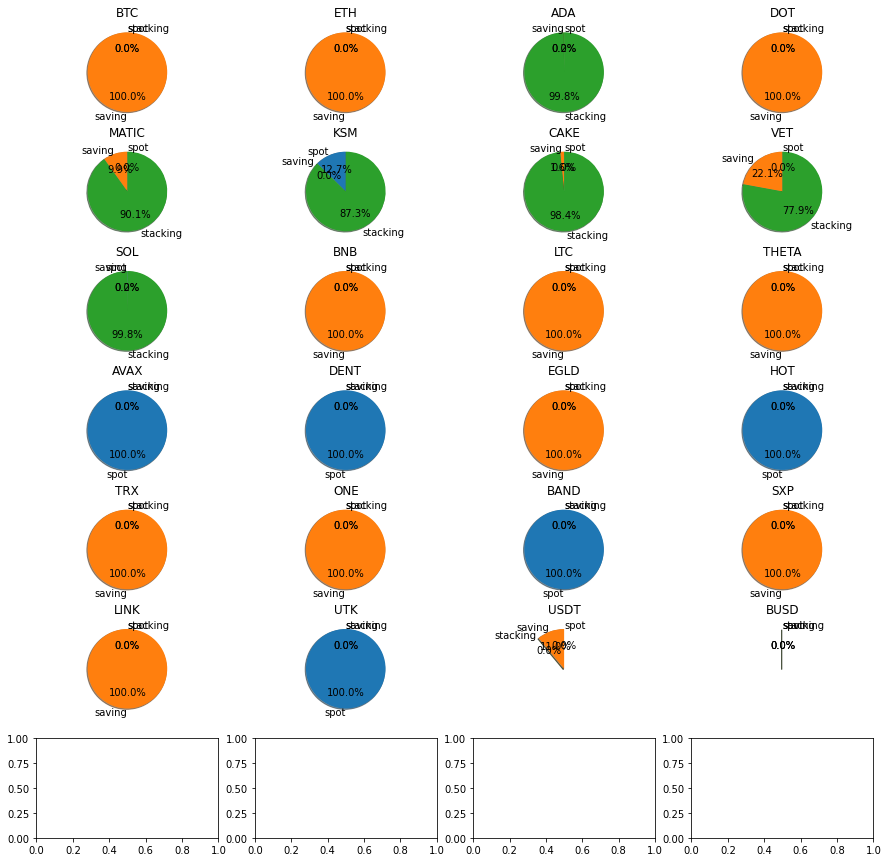

In [16]:
plt.figure(1, figsize=(10, 10))
chats_labels = my_coins
num_columns = 4                                
num_rows  = len(chats_labels) // 4 + 1
fig, ax = plt.subplots(num_rows,num_columns)
label = ['spot', 'saving', "stacking"]
for i, coin in enumerate(chats_labels):
    data = [wallet[coin]['Spot_value'], wallet[coin]['Saving_value'], wallet[coin]['Stack_value']]
    ax[i//4,i%4].set_title(coin)                           # Add 1 to j index
    ax[i//4,i%4].pie(data, labels=label,                 # Add 1 to j index
                autopct='%1.1f%%', shadow=True, startangle=90)
fig.set_size_inches(15,15)
plt.show()

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import IntProgress, widgets

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#FF4600'
c2='#3DD600' 

color = colorFader(c1,c2,mix=0.5)
for asset in my_coins:
    value=wallet[asset]['Current_market_price']
    maxi=wallet[asset]['ATH']
    color = colorFader(c1,c2,mix=wallet[asset]['ATH_percent'])
    
    display(widgets.FloatProgress(
        value=value,
        min=0,
        max=maxi,
        description=asset,
        bar_style='success',
        style={'bar_color': color},
        orientation='horizontal',
    readout=True,
    readout_format='.1f',
    disabled=False
    ))
    
    display(widgets.HTML(
    value = asset + ": "+str(wallet[asset]['Current_market_price']) + ' / '+ str(wallet[asset]['ATH'])
    ))


FloatProgress(value=34789.78, bar_style='success', description='BTC', max=59500.0, style=ProgressStyle(bar_col…

HTML(value='BTC: 34789.78 / 59500.0')

FloatProgress(value=2381.01, bar_style='success', description='ETH', max=4372.72, style=ProgressStyle(bar_colo…

HTML(value='ETH: 2381.01 / 4372.72')

FloatProgress(value=1.4321, bar_style='success', description='ADA', max=2.47, style=ProgressStyle(bar_color='#…

HTML(value='ADA: 1.4321 / 2.47')

FloatProgress(value=17.162, bar_style='success', description='DOT', max=49.78, style=ProgressStyle(bar_color='…

HTML(value='DOT: 17.162 / 49.78')

FloatProgress(value=1.15282, bar_style='success', description='MATIC', max=2.7, style=ProgressStyle(bar_color=…

HTML(value='MATIC: 1.15282 / 2.7')

FloatProgress(value=240.23, bar_style='success', description='KSM', max=625.0, style=ProgressStyle(bar_color='…

HTML(value='KSM: 240.23 / 625.0')

FloatProgress(value=15.841, bar_style='success', description='CAKE', max=42.98, style=ProgressStyle(bar_color=…

HTML(value='CAKE: 15.841 / 42.98')

FloatProgress(value=0.08513, bar_style='success', description='VET', max=0.25, style=ProgressStyle(bar_color='…

HTML(value='VET: 0.08513 / 0.25')

FloatProgress(value=37.005, bar_style='success', description='SOL', max=58.38, style=ProgressStyle(bar_color='…

HTML(value='SOL: 37.005 / 58.38')

FloatProgress(value=337.84, bar_style='success', description='BNB', max=691.77, style=ProgressStyle(bar_color=…

HTML(value='BNB: 337.84 / 691.77')

FloatProgress(value=141.54, bar_style='success', description='LTC', max=413.49, style=ProgressStyle(bar_color=…

HTML(value='LTC: 141.54 / 413.49')

FloatProgress(value=6.425, bar_style='success', description='THETA', max=13.2, style=ProgressStyle(bar_color='…

HTML(value='THETA: 6.425 / 13.2')

FloatProgress(value=13.646, bar_style='success', description='AVAX', max=43.885, style=ProgressStyle(bar_color…

HTML(value='AVAX: 13.646 / 43.885')

FloatProgress(value=0.0025091, bar_style='success', description='DENT', max=0.011699, style=ProgressStyle(bar_…

HTML(value='DENT: 0.0025091 / 0.011699')

FloatProgress(value=96.91, bar_style='success', description='EGLD', max=205.0, style=ProgressStyle(bar_color='…

HTML(value='EGLD: 96.91 / 205.0')

FloatProgress(value=0.006184, bar_style='success', description='HOT', max=0.01684, style=ProgressStyle(bar_col…

HTML(value='HOT: 0.006184 / 0.01684')

FloatProgress(value=0.06561, bar_style='success', description='TRX', max=0.17, style=ProgressStyle(bar_color='…

HTML(value='TRX: 0.06561 / 0.17')

FloatProgress(value=0.08753, bar_style='success', description='ONE', max=0.18858, style=ProgressStyle(bar_colo…

HTML(value='ONE: 0.08753 / 0.18858')

FloatProgress(value=6.968, bar_style='success', description='BAND', max=20.673, style=ProgressStyle(bar_color=…

HTML(value='BAND: 6.968 / 20.673')

FloatProgress(value=2.157, bar_style='success', description='SXP', max=5.87, style=ProgressStyle(bar_color='#b…

HTML(value='SXP: 2.157 / 5.87')

FloatProgress(value=20.885, bar_style='success', description='LINK', max=53.0, style=ProgressStyle(bar_color='…

HTML(value='LINK: 20.885 / 53.0')

FloatProgress(value=0.2405, bar_style='success', description='UTK', max=1.065, style=ProgressStyle(bar_color='…

HTML(value='UTK: 0.2405 / 1.065')

FloatProgress(value=0.0, bar_style='success', description='USDT', max=0.0, style=ProgressStyle(bar_color='#ff4…

HTML(value='USDT: 0 / 0')

FloatProgress(value=0.9996, bar_style='success', description='BUSD', max=1.0029, style=ProgressStyle(bar_color…

HTML(value='BUSD: 0.9996 / 1.0029')

In [18]:
 orders_history = client.get_all_orders(symbol='CAKEUSDT')
 orders_history

[{'symbol': 'CAKEUSDT',
  'orderId': 141340421,
  'orderListId': -1,
  'clientOrderId': 'and_4bb3d50ade514326a57b280ac15f431f',
  'price': '16.00000000',
  'origQty': '3.12500000',
  'executedQty': '3.12500000',
  'cummulativeQuoteQty': '50.00000000',
  'status': 'FILLED',
  'timeInForce': 'GTC',
  'type': 'LIMIT',
  'side': 'BUY',
  'stopPrice': '0.00000000',
  'icebergQty': '0.00000000',
  'time': 1621936054378,
  'updateTime': 1621937428385,
  'isWorking': True,
  'origQuoteOrderQty': '0.00000000'},
 {'symbol': 'CAKEUSDT',
  'orderId': 151460341,
  'orderListId': -1,
  'clientOrderId': 'and_b10e24daad5f443c84ac17ed6c1b6be3',
  'price': '14.10000000',
  'origQty': '0.80000000',
  'executedQty': '0.80000000',
  'cummulativeQuoteQty': '11.28000000',
  'status': 'FILLED',
  'timeInForce': 'GTC',
  'type': 'LIMIT',
  'side': 'BUY',
  'stopPrice': '0.00000000',
  'icebergQty': '0.00000000',
  'time': 1622314224253,
  'updateTime': 1622314297963,
  'isWorking': True,
  'origQuoteOrderQty':